## Importing libs and setting plotting parameters

In [2]:
import pandas as pd
import seaborn as sns
import random
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import  pickle

import os
import sys 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.process_data import *

mp.style.use('ggplot')
mp.rcParams['font.family'] = "serif"
mp.rcParams['font.size'] = 24
sns.set(style="darkgrid", font_scale=1.5)

## Reading trainning data

In [3]:
train_data = pd.read_parquet("../data/raw/train.parquet")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2889113 entries, 3281 to 29337019
Data columns (total 14 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id                            float64       
 1   desembolso                    datetime64[ns]
 2   vencimento                    datetime64[ns]
 3   valor_emprestado              float64       
 4   pgto_diario_esperado          float64       
 5   dia                           datetime64[ns]
 6   dias_pos_desembolso           float64       
 7   divida_total                  float64       
 8   divida_principal              float64       
 9   pagamento_diario              float64       
 10  amortizacao_principal_diario  float64       
 11  transacionado                 float64       
 12  subsegmento                   object        
 13  y                             float64       
dtypes: datetime64[ns](3), float64(10), object(1)
memory usage: 330.6+ MB


In [4]:
train_data.describe()

,id,valor_emprestado,pgto_diario_esperado,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
count,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06
mean,2.953396e+04,1.316104e+04,5.421204e+01,1.021915e+02,8.167070e+03,7.945753e+03,7.140171e+01,5.897608e+01,5.693074e+02,7.410198e-02
std,1.717566e+04,1.557298e+04,6.012586e+01,7.258616e+01,1.202128e+04,1.164722e+04,2.822804e+02,2.719035e+02,1.426674e+03,2.619368e-01
min,6.000000e+00,1.000100e+02,2.759000e-01,0.000000e+00,1.010000e+00,-3.695580e+01,-7.279580e+03,-7.273392e+03,-1.000000e+05,0.000000e+00
25%,1.444600e+04,3.600000e+03,1.563170e+01,4.200000e+01,1.469280e+03,1.436800e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.065700e+04,7.900000e+03,3.395960e+01,8.900000e+01,4.017630e+03,3.922101e+03,0.000000e+00,0.000000e+00,1.084000e+02,0.000000e+00
75%,4.439600e+04,1.612000e+04,6.882470e+01,1.510000e+02,9.764290e+03,9.489511e+03,5.781000e+01,3.824060e+01,6.035600e+02,0.000000e+00
max,5.944300e+04,2.129920e+05,5.913233e+02,3.610000e+02,2.130434e+05,2.129920e+05,1.210000e+05,1.202322e+05,1.785886e+05,1.000000e+00


In [5]:
train_data.head()

,id,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,y
3281,6.0,2019-03-25,2019-12-26,7100.0,33.7107,2019-03-25,0.0,7197.98,7100.0,0.00,0.0,664.0,None,0.0
3282,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-26,1.0,7212.25,7100.0,0.00,0.0,0.0,None,0.0
3283,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-27,2.0,7226.54,7100.0,0.00,0.0,150.0,None,0.0
3284,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-28,3.0,7207.22,7100.0,33.64,0.0,0.0,None,0.0
3285,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-29,4.0,7221.51,7100.0,0.00,0.0,0.0,None,0.0


## Changing types of train data

In [6]:
dtypes = {
    'id': int,
    'dias_pos_desembolso': int,
    'y': int
}

train_data.desembolso = train_data.desembolso.dt.date
train_data.vencimento = train_data.vencimento.dt.date
train_data.dia = train_data.dia.dt.date

train_data = train_data.astype(dtypes)

## Organizing db to ease the queries speed.

#### Here the idea is to generate a DataFrame containing the constant atributes of a company`s loan where each row is going to represent a loan from a single company. Sequentialy, a dictionary is going to be generate where the key is the id of the company`s loan and the value is a DataFrame with the history of the loan. This operation optimizes the search time and the generation of graphs.
#### The function `df_split_between_constant_and_timeseries_attributes` used to perform this operation is avaiable in `utils/process_data.py`. This function took approximately 2 min to run in my machine. If you want to skip this time ignore the following cell and go forward to the next one.

In [ ]:
%%time

constant_attributes = ['desembolso', 'vencimento', 'valor_emprestado',
    'pgto_diario_esperado', 'subsegmento', 'y']

timeseries_attributes = ['dia', 'dias_pos_desembolso', 'divida_total',
    'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario',
    'transacionado']

train_data.sort_values(by=['id', 'dias_pos_desembolso'], axis=0, inplace=True)

df_loans, dict_loan_timeseries = from_sorted_df_split_between_constant_and_timeseries_attributes(train_data, constant_attributes, timeseries_attributes)

with open('../data/processed/train_timeseries_attributes.p', 'wb') as fp:
    pickle.dump(dict_loan_timeseries, fp, protocol=pickle.HIGHEST_PROTOCOL)


# Saving data into `data/processed` folder
df_loans.to_csv('../data/processed/train_constant_attributes.csv', index=True, index_label='id')

In [1]:
constant_attributes = ['desembolso', 'vencimento', 'valor_emprestado',
    'pgto_diario_esperado', 'subsegmento', 'y']

### Null values in `subsegmento` are filled with `N/A`, `valor_emprestado` is set as an attribute with type `int`, and the columns `desembolso` and `vencimento` are set to datetime type. Since now id values are unique, they are set as the index of the DataFrame.

In [7]:
df_loans = pd.read_csv('../data/processed/train_constant_attributes.csv')

with open('../data/processed/train_timeseries_attributes.p', 'rb') as handle:
    dict_loan_timeseries = pickle.load(handle)

df_loans["desembolso"] = pd.to_datetime(df_loans["desembolso"], format="%Y-%m-%d")
df_loans["vencimento"] = pd.to_datetime(df_loans["vencimento"], format="%Y-%m-%d")
df_loans['subsegmento'].fillna('N/A', inplace=True)

df_loans.index = df_loans['id']
df_loans.drop(columns=['id'], inplace=True)

In [8]:
df_loans.head()

,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,subsegmento,y
id,,,,,,
6,2019-03-25,2019-12-26,7100.0,33.8852,N/A,0
8,2019-03-25,2019-12-26,6900.0,32.9307,N/A,0
9,2019-03-25,2019-12-26,42500.0,175.5301,N/A,0
11,2019-03-25,2019-12-26,4200.0,19.2553,Alimentação Rápida,0
12,2019-03-06,2019-12-05,7700.0,34.0856,Bares e Restaurantes,0


In [8]:
dict_loan_timeseries[6]

,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado
0,2019-03-25,0,7197.98,7100.0000,0.00,0.0000,664.0
1,2019-03-26,1,7212.25,7100.0000,0.00,0.0000,0.0
2,2019-03-27,2,7226.54,7100.0000,0.00,0.0000,150.0
3,2019-03-28,3,7207.22,7100.0000,33.64,0.0000,0.0
4,2019-03-29,4,7221.51,7100.0000,0.00,0.0000,0.0
...,...,...,...,...,...,...,...
268,2019-12-18,268,122.29,122.2892,56.07,55.7172,0.0
269,2019-12-19,269,122.53,122.2892,0.00,0.0000,0.0
270,2019-12-20,270,122.77,122.2892,0.00,0.0000,2527.0
271,2019-12-21,271,123.02,122.2892,0.00,0.0000,0.0


# 0. Exploratory Analysis of the Constant Attributes

## 0.1  What is the default distribution among the companies?

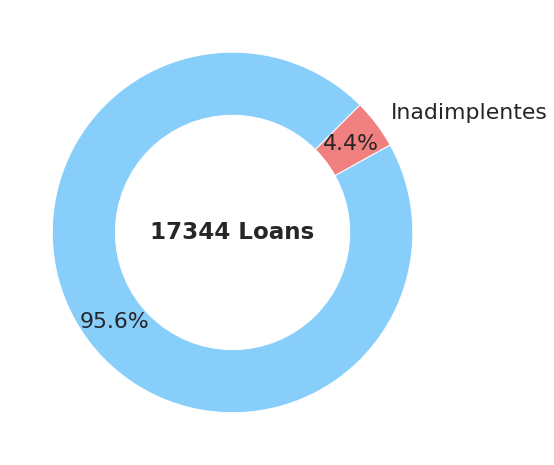

In [9]:
n_companies = df_loans['y'].value_counts().sum()
default_count = df_loans['y'].value_counts()
default_count.name = ""
default_count.index = default_count.index.map({0:"", 1:"Inadimplentes"})

ax = default_count.plot.pie(figsize=(8,8), autopct="%1.1f%%", startangle=45, colors=['lightskyblue', 'lightcoral'], pctdistance=0.82, textprops={'fontsize': 22})

my_donut=plt.Circle( (0,0), 0.65, color='white')
p=plt.gcf()
ax.text(0,0, f"{n_companies} Loans", ha='center', va='center', size=23, weight='bold')
p.gca().add_artist(my_donut)

# plt.axis("equal")
plt.tight_layout()

### This donut chart shows (fortunately) that the dataset is imbalanced. The number of default companies disproportionately smaller than the companies that paid off the credit. This dataset particularity should be dealt in the ml models.

## 0.2 What is the distribution of loan value?

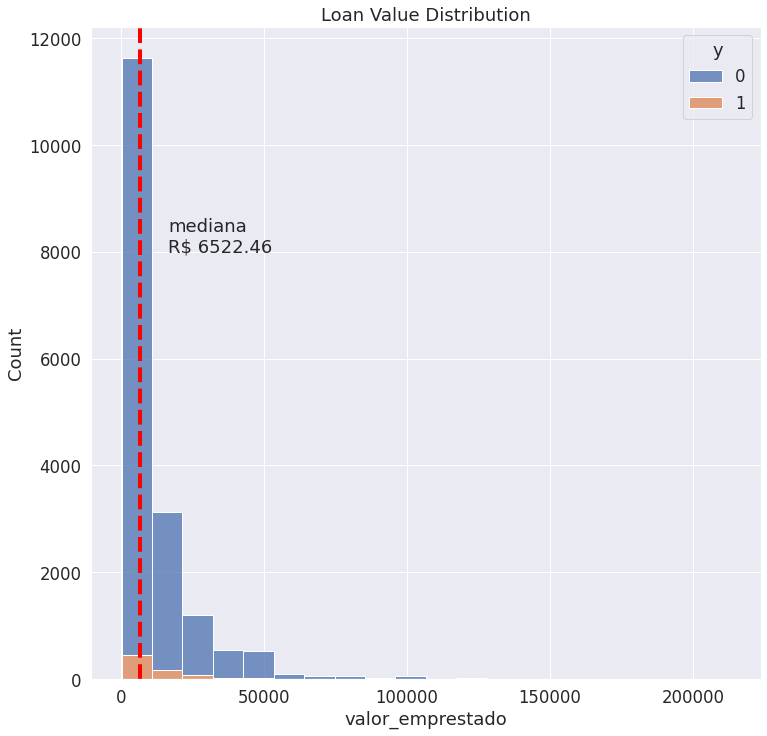

In [10]:
loan_value_per_id = df_loans[['valor_emprestado', 'y']]
median_loan_value = df_loans['valor_emprestado'].median()

fig, ax = plt.subplots(figsize=(12,12))
sns.histplot(ax=ax, data=loan_value_per_id, stat='count', x='valor_emprestado', hue='y', multiple='stack', bins=20)
vline = plt.axvline(median_loan_value, 0,1, c='red', linestyle='--', linewidth=4)
plt.annotate(f"mediana\nR$ {median_loan_value:.2f}", (median_loan_value + 10000, 8000))
plt.title("Loan Value Distribution");

## 0.3 What is the Distribution of the Expected Daily Payment?

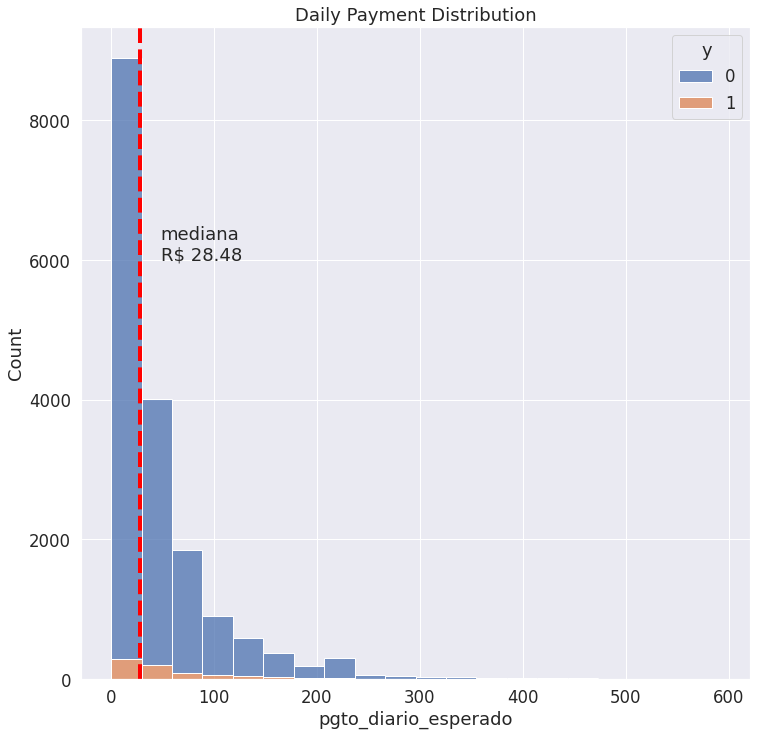

In [11]:
daily_payment = df_loans[['pgto_diario_esperado', 'y']]
median_daily_payment = df_loans['pgto_diario_esperado'].median()

fig, ax = plt.subplots(figsize=(12,12))
sns.histplot(ax=ax, data=daily_payment, x='pgto_diario_esperado', hue='y', multiple='stack', bins=20)
plt.axvline(median_daily_payment, 0,1, c='red', linestyle='--', linewidth=4)
plt.annotate(f"mediana\nR$ {median_daily_payment:.2f}", (median_daily_payment + 20, 6000))
plt.title("Daily Payment Distribution");

## 0.4  What was the period in which most loans were taken?

<AxesSubplot:xlabel='desembolso', ylabel='Count'>

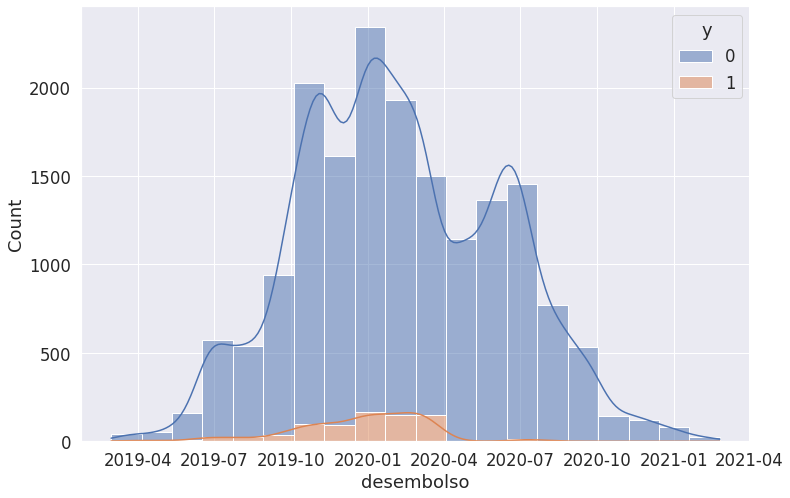

In [12]:
loan_date = df_loans[['desembolso', 'y']]

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(ax=ax, data=loan_date, x='desembolso', hue='y', multiple='stack', bins=20, kde=True)

#### As expected, the period in which the most loans were taken was during the beginning of the pandemic. As a consequence, in this period there were also a greater number of defaulters.

## 0.5 Is there any correlation between the maximum time established for the payment of the loan and the chance of default?

<AxesSubplot:xlabel='duracao_esperada_credito', ylabel='Count'>

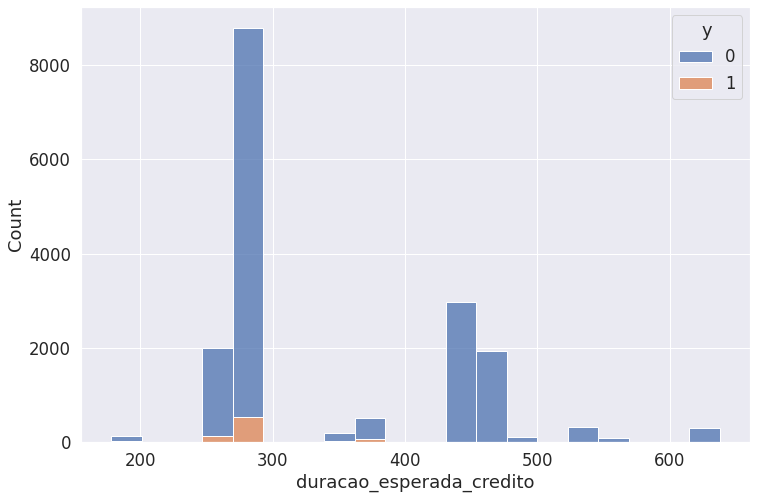

In [13]:
max_loan_time = pd.DataFrame(data={
    'duracao_esperada_credito': (df_loans['vencimento'] - df_loans['desembolso']).dt.days,
    'y': df_loans['y']
})

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(ax=ax, data=max_loan_time, x='duracao_esperada_credito', hue='y', multiple='stack', bins=20)

## 0.5 Is there a relationship between the segment and default?

In [14]:
# dictionary to map subsegments in broader sectors
sectors = {
    'Food & Beverage': ['Comércio de Alimentos', 'Alimentação Rápida', 'Bares e Restaurantes', 'Comércio de Bebidas', 'Supermercados'],
    'Fashion and Sports': ['Vestuário', 'Calçados', 'Artigos Esportivos', 'Acessórios, Bolsas e Bijuterias'],
    'Construction, Vehicles and Industry': ['Materiais de Construção', 'Autopeças e Acessórios', 'Comércio de Veículos', 'Gás GLP, Lubrificantes e Outros', 'Reformas e Obras em Geral', 'Postos de Gasolina', 'Estacionamentos e Lava-rápidos', 'Equipamentos de Uso Comercial e Industrial', 'Locação de Veículos'],
    'Services': ['Oficinas Automotivas', 'Salão de Beleza', 'Conserto de Produtos e Reparos de Peças', 'Outros Serviços - Outros', 'Delivery e Entrega', 'Telecomunicações', 'Academias e Clubes', 'Clinicas de Estética e Massagem', 'Associação', 'Cias Aéreas', 'Jornais e Revistas - Conteúdo Físico', 'Serviços Corporativos - Outros', 'Hotéis / Resorts / Pousadas / Motéis', 'Festas e Eventos', 'Gráfica, Impressão e Xerox', 'Entretenimento e Turismo', 'Consultorias', 'Logística e Mobilidade - Outros', 'Marketing', 'Serviços Imobiliários', 'Segurança', 'Táxi/Carona', 'Paisagismo e Jardinagem', 'Serviços Financeiros', 'Casa e Decoração - Outros'],
    'Health': ['Óticas e Óculos', 'Drogarias e Farmácias', 'Outros Serviços de Saúde', 'Odontologia', 'Veterinários', 'Médicina', 'Outros Produtos de Saúde e Beleza', 'Hospitais e Laboratórios'],
    'Business': ['Móveis', 'Outros Comércios - Outros', 'Eletrodomésticos', 'Armarinhos e Tecido', 'Tabacaria', 'Cama, Mesa e Banho', 'Cosméticos e Perfumaria', 'Loja de Presentes','Lojas de Departamento', 'Jogos e Brinquedos Físicos', 'Joalherias, Relojoarias e Pratarias', 'Floricultura', 'Petshops', 'Artigos Religiosos e Antiguidades', 'Artigos de Decoração', 'Instrumentos Musicais, CDs, DVDs e Outros'],
    'Education': ['Extracurriculares, Autoescola e Outros', 'Ensino Básico', 'Livrarias e Papelarias', 'Ensino Superior e Técnico'],
    'Computing': ['Eletrônicos', 'Softwares e Eletrônica Integrada']
}

# checando se todos os subsegmentos foram registrados. O codigo abaixo deve gerar uma saida de texto N/A
flat_list = [item for sublist in list(sectors.values()) for item in sublist]
for segment in df_loans['subsegmento'].unique():
    if not flat_list.count(segment):
        print(segment)

N/A


In [15]:
def return_key_if_contains_value(dictionary, my_value):
    for key, value in dictionary.items():
        if my_value in value:
            return key

df_loans['segmento'] = df_loans['subsegmento'].map(lambda segment: return_key_if_contains_value(sectors, segment))
df_loans['segmento'] = df_loans['segmento'].fillna('N/A')

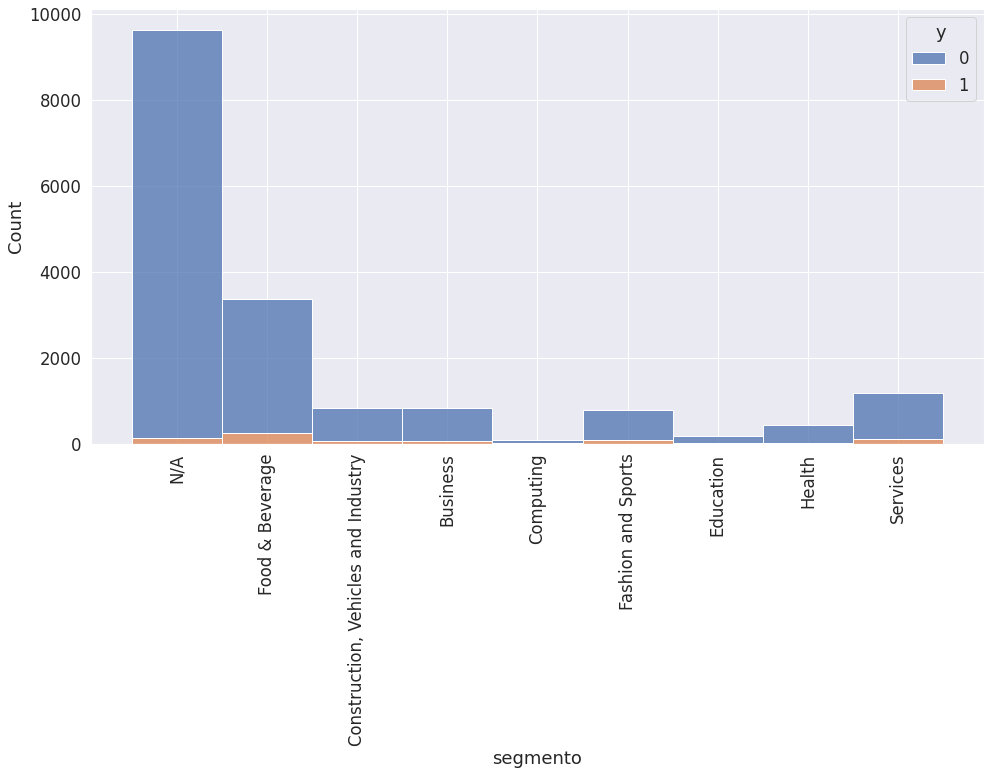

In [16]:
fig, ax = plt.subplots(figsize=(16,8))


g = sns.histplot(data=df_loans, x='segmento', hue='y', multiple='stack')
plt.xticks(rotation=90);

# 1. Exploratory Analysis of the attributes that vary with time

## 1.1 Are there any unregistered days of the loan in the dataset?

### The first analysis will be related to the `dias_pos_desembolso` attribute. We will check if that for each loan all days are registered i.e. the days registered start at 0 and follows a sequential (1,2,3,4,...) order without jumping any day. The function used here `check_if_list_of_ints_start_0_and_is_sorted` is available in `utils/process_data.py`

In [9]:
missing_days_index = []

for loan_index, loan_timeseries in dict_loan_timeseries.items():
    loan_timeseries_tmp = dict_loan_timeseries[loan_index]
    days_after_loan = loan_timeseries_tmp['dias_pos_desembolso']
    if not check_if_list_of_ints_start_0_and_is_sorted(days_after_loan):
        missing_days_index.append(loan_index)
        
print(f"{len(missing_days_index)} loans with missing rows in the dataset")

341 loans with missing rows in the dataset


#### There are 341 loans where there are missing rows

In [10]:
defaults = []
for missing_day in missing_days_index:
    defaults.append(df_loans.loc[missing_day, 'y'])
    
print(f"From {len(missing_days_index)} loans with missing rows, {sum(defaults)} are default")

From 341 loans with missing rows, 0 are default


#### Since the dataset is unbalanced (only 5% loans are default) and none of the loans with missing days are Default, i will not give myself trouble imputting theses missing values, thus, these loans are going to be discarted from the dataset.

In [11]:
df_loans.drop(missing_days_index, inplace=True)
train_data.drop(train_data.index[train_data['id'].isin(missing_days_index)], inplace=True)
train_data.reset_index(drop=True, inplace=True)

for missing_day in missing_days_index:
    dict_loan_timeseries.pop(missing_day)

In [29]:
dias_pos_desembolso_por_id = train_data.groupby('id')['dias_pos_desembolso'].max()
dias_pos_desembolso_por_id.value_counts()

273    585
271    489
272    361
270    336
269    311
      ... 
358      1
338      1
1        1
336      1
0        1
Name: dias_pos_desembolso, Length: 358, dtype: int64

In [31]:
# the loan with just one row
dias_pos_desembolso_por_id.index[dias_pos_desembolso_por_id == 0]

Int64Index([46526], dtype='int64', name='id')

## 1.2 If the loans stop being registered before the last possible day of the loan (`vencimento`) this means that the loan was paid?

In [26]:
train_data['tempo_maximo_divida'] = (
    train_data.vencimento - train_data.desembolso).dt.days

check_default_for_early_ended_loans = train_data.groupby('id')[['tempo_maximo_divida', 'dias_pos_desembolso', 'y']].agg({
    'tempo_maximo_divida': 'max',
    'dias_pos_desembolso': 'max',
    'y': 'median'
})
check_default_for_early_ended_loans['dif_tempo_pagamento'] = check_default_for_early_ended_loans[
    'tempo_maximo_divida'] - check_default_for_early_ended_loans['dias_pos_desembolso']

dtypes = {
    'dias_pos_desembolso': int,
    'dif_tempo_pagamento': int,
    'y': int
}

check_default_for_early_ended_loans = check_default_for_early_ended_loans.astype(
    dtypes)
check_default_for_early_ended_loans = check_default_for_early_ended_loans.loc[
    check_default_for_early_ended_loans['dif_tempo_pagamento'] > 0]

In [29]:
print(f"From {check_default_for_early_ended_loans.y.size} payments that ended before the last day, only {(check_default_for_early_ended_loans.y== 1).sum()} were Default")

From 14923 payments that ended before the last day, only 86 were Default


#### So, the answer of 1.2 is false.

#### Lets assume that at least two transactions are needed... index 46526 is also going to be dropped

## 1.2 Exploring Timeseries Attributes

### The exploratory Analysis of the timeseries attributes is done in two ways. First, a dashboard is created in the notebook `02_dashboard.ipynb` to individually investigate the variation of timeseries attributes. Second, in the following cells, the attributes `divida_total`, `divida_principal`, `pagamento_diario`, 	`amortizacao_principal_diario` and	`transacionado` are normalized according to `valor_emprestado`. This tranformation should give a more comparative bias in between loans.

In [10]:
timeseries_attributes = ['divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario', 'transacionado']
# Getting the numpy array to improve performance
timeseries_train_values = train_data[timeseries_attributes].values

In [11]:
%%time
#this loop takes approx. 1 min to run

for loan_index in df_loans.index:
    loan_value = df_loans.loc[loan_index, 'valor_emprestado']
    loan_index_in_array = train_data.index[train_data['id'].isin([loan_index])]
    timeseries_train_values[loan_index_in_array, :] /= loan_value
    
train_data[timeseries_attributes] = timeseries_train_values

CPU times: user 1min 23s, sys: 41.3 ms, total: 1min 23s
Wall time: 1min 23s


In [49]:
train_data[timeseries_attributes].describe()

,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado
count,2.832427e+06,2.832427e+06,2.832427e+06,2.832427e+06,2.832427e+06
mean,6.188209e-01,5.966071e-01,6.279934e-03,5.161519e-03,6.171986e-02
std,3.406908e-01,3.108437e-01,1.673598e-02,1.554514e-02,2.820156e-01
min,1.133471e-05,1.135261e-05,-2.331914e-01,-2.331914e-01,-1.871988e+01
25%,3.441378e-01,3.407333e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.529740e-01,6.431584e-01,0.000000e+00,0.000000e+00,1.664167e-02
75%,8.983709e-01,8.795402e-01,6.582097e-03,4.730376e-03,6.839404e-02
max,2.529212e+00,1.044610e+00,1.987472e+00,9.983642e-01,1.651247e+02


### Some interesting features of the dataset are show in the descriptive statistic table above. 
#### Some loans manage inscrease the original value taken as loan by 250% (max(`divida_total`) ~= 2.5). I would presume that this loan ended up as default...
#### There are some entries of `pagamento_diario`,	`amortizacao_principal_diario`,	`transacionado`  as negative values. I would assume that these were days where some money were returned to their clients.
#### Also, some loan takers paid the whole debt, probably, in just one day. This is clean in the `pagamento_diario` where its max value ~= 1.98

#### The distribution of these values can be seen in the graph bellow

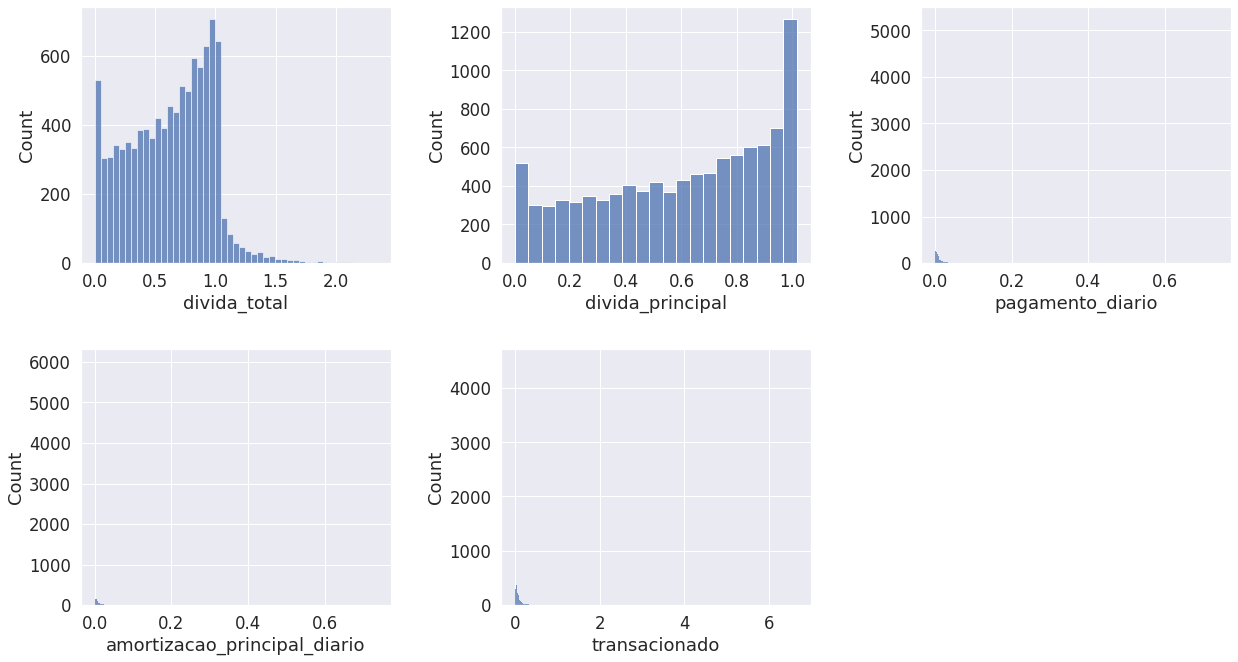

In [48]:
import random

# 10000 samples are randomnly selected. This sampling speed up the graphs.
np.random.seed(42)
random_indices = np.random.choice(timeseries_train_values.shape[0], 
                                  size=10000, 
                                  replace=False)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
ax = ax.flatten()
ax[-1].set_axis_off()

for i, attribute in enumerate(timeseries_attributes):
    sns.histplot(ax=ax[i], data=timeseries_train_values[random_indices,i])
    ax[i].set_xlabel(attribute)
    
fig.tight_layout(pad=2)

### 1.3 Investigating Negative numerical values

In [56]:
neg_payment = train_data['pagamento_diario'] < 0
neg_amortization = train_data['amortizacao_principal_diario'] < 0
neg_transacted = train_data['transacionado'] < 0

neg_values = neg_amortization | neg_payment | neg_transacted

neg_values_indexes = train_data.loc[neg_values, 'id'].unique().astype(int)
neg_values_indexes_count = train_data.loc[neg_values, 'id'].value_counts()
print(neg_values_indexes_count)

43587    21
13584    17
25742    16
12778    16
22067    15
         ..
22535     1
48632     1
38059     1
7039      1
14338     1
Name: id, Length: 363, dtype: int64


#### Individually investigating these values in the dashboard in the archive `02_dashboard.ipynb` we can infer that:
#### For id 43587, 25742, 12778, 22067, `pagamento_diario` high peaks  are followed by low valleys. Probably this is due to returning money to the client.
#### For id 13584, `transacionado` is routinely negative. Since it is from the segment `Academias e Clubes`, i would assume that it is from clients asking return on the monthly membership payment.
#### From this selective investigation, I will consider that these negative values are part of the routine of the loan takers.

### 1.3 Investigating High values of `pagamento_diario` and `amortizacao_principal_diario`

In [105]:
#Selecting normalized values of pagamento_diario, amortizacao_principal_diario above 1
payment_high_values = train_data[['pagamento_diario', 'amortizacao_principal_diario']]  > 1
high_values_index = payment_high_values.index[payment_high_values['pagamento_diario'] | payment_high_values['amortizacao_principal_diario']]
 
# Here, for each row in high_values_index, i also gonna add the row that preceded to observe the state of the loan before this high payments
new_high_values_index = []
days = []
for index in high_values_index:
    new_high_values_index.append(index-1)
    new_high_values_index.append(index)
    days.append
    
high_values_payment = train_data.loc[new_high_values_index, ['id','dia', 'divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario']]
high_values_payment['dia'] = [1,2] * (high_values_payment.shape[0] // 2)
high_values_payment

In [127]:
high_values_payment

,id,dia,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario
90137,1725,1,1.109594,1.000000,0.000000,0.000000
90138,1725,2,0.009209,0.009209,1.102233,0.990791
136725,2571,1,1.083047,1.000000,0.000000,0.000000
136726,2571,2,0.016381,0.016381,1.069153,0.983619
168426,3150,1,1.207176,1.000000,0.000000,0.000000
168427,3150,2,0.066330,0.066329,1.142857,0.933671
224654,4062,1,1.034065,0.997866,0.000000,0.000000
224655,4062,2,0.000894,0.000894,1.034065,0.996972
763940,15669,1,2.033579,1.000000,0.000000,0.000000
763941,15669,2,0.906488,0.906487,1.133019,0.093513


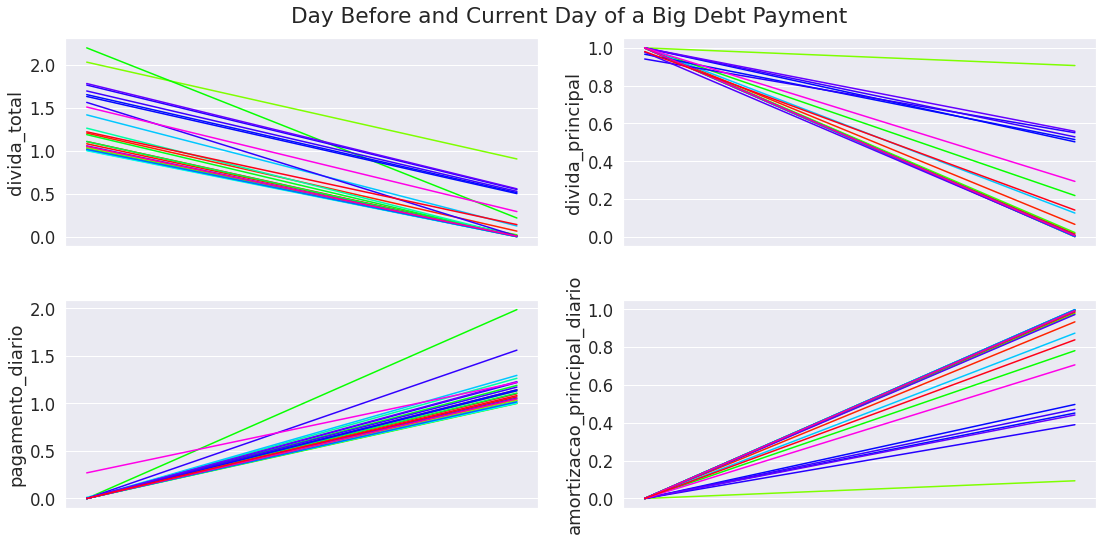

In [130]:
attributes = ['divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=True)
ax = ax.flatten()
fig.tight_layout(pad=2)

for i, attribute in enumerate(attributes):
    sns.lineplot(ax=ax[i], data=high_values_payment, x='dia', y=attribute, hue='id', palette="hsv")
    ax[i].get_legend().remove()
    ax[i].set_xticks([])
    
plt.suptitle("Day Before and Current Day of a Big Debt Payment");

#### The table and the graphs above shows that nothing out of normal is happening... Almost the entire sum of the debt is being paid in one day, so a high payment becomes a big debt reduction.